# Session: Semantic Segmention with Camvid dataset 

### Import packages

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import os 
import cv2
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing import image

## Download Dataset

In [19]:
!wget -q https://www.dropbox.com/s/ghvpyv3hbw67cpt/camvid.tar

^C


In [0]:
!wget -q http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt

In [20]:
!tar -xvf camvid.tar  > /dev/null; echo " done."

 done.


In [21]:
!ls -R | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/'

   .
   |-camvid
   |---images
   |---labels
   |-logs
   |---train
   |-models-dr
   |-sample_data


In [0]:
rm camvid/images/test.txt

## Distributing images and masks to folders

In [6]:
image_dir = 'camvid/images'
masks_dir = 'camvid/labels/'
image_list = os.listdir(image_dir)
mask_list = os.listdir(masks_dir)
image_list.sort()
mask_list.sort()
print(f'Found {len(image_list)} images and {len(mask_list)} masks')

Found 702 images and 701 masks


In [7]:
print(image_list[:5])
print(mask_list[:5])

['0001TP_006690.png', '0001TP_006720.png', '0001TP_006750.png', '0001TP_006780.png', '0001TP_006810.png']
['0001TP_006690_P.png', '0001TP_006720_P.png', '0001TP_006750_P.png', '0001TP_006780_P.png', '0001TP_006810_P.png']


## Display dataset images along with masks

In [8]:
idx = np.random.randint(0, len(image_list), 10)
for i in idx:
    test = image.load_img(f'{image_dir}/{image_list[i]}', target_size=(300, 400))
    test_mask = image.load_img(f'{masks_dir}/{mask_list[i]}', target_size=(300, 400), grayscale=True)
    test = image.img_to_array(test).astype('uint8')
    test_mask = np.squeeze(image.img_to_array(test_mask)).astype('uint8')

    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(121)
    ax.set_title(f'Image {test.shape}')
    ax.imshow(test)

    ax2 = fig.add_subplot(122)
    ax2.set_title(f'GT Mask {test_mask.shape}')
    ax2.imshow(test_mask)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
## Read class labels .txt file
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [10]:
# For each colour there is a particular class, there are 32 semantic classes

label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
print(len(label_codes))
label_codes[:5], label_names[:5]

32


([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [11]:
# Converting colour code to particular id
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}
print(id2code)

{0: (64, 128, 64), 1: (192, 0, 128), 2: (0, 128, 192), 3: (0, 128, 64), 4: (128, 0, 0), 5: (64, 0, 128), 6: (64, 0, 192), 7: (192, 128, 64), 8: (192, 192, 128), 9: (64, 64, 128), 10: (128, 0, 192), 11: (192, 0, 64), 12: (128, 128, 64), 13: (192, 0, 192), 14: (128, 64, 64), 15: (64, 192, 128), 16: (64, 64, 0), 17: (128, 64, 128), 18: (128, 128, 192), 19: (0, 0, 192), 20: (192, 128, 128), 21: (128, 128, 128), 22: (64, 128, 192), 23: (0, 0, 64), 24: (0, 64, 64), 25: (192, 64, 128), 26: (128, 128, 0), 27: (192, 128, 192), 28: (64, 0, 64), 29: (192, 192, 0), 30: (0, 0, 0), 31: (64, 192, 0)}


## Create Unet code block

In [0]:
## Encoding layers which give feature maps
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#VGGNET

### Decoding layers to produce masks
def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=32, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
#    output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    model.summary()
    return model    

In [13]:
# Setting batch_size, image height and width, number of classes which in this case is 32
batch_size = 8
samples = len(image_list)
steps = samples//batch_size
img_height, img_width = 128, 128
classes = 32
filters_n = 32
print(f'Batch size = {batch_size}\nSteps per epoch = {steps}')

Batch size = 8
Steps per epoch = 87


## Custom data generator

In [0]:
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras.callbacks import Callback

class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.randint(0, samples, batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image.img_to_array(image.load_img(f'{image_dir}/{image_list[i]}', target_size=(img_height, img_width)))/255.   
            mask = image.img_to_array(image.load_img(f'{masks_dir}/{mask_list[i]}', grayscale=True, target_size=(img_height, img_width)))
#             mask = np.resize(mask,(img_height*img_width, classes))
            batch_y.append(mask)
            batch_x.append(_image)
        return np.array(batch_x), np.array(batch_y)


## Model Building and Training

In [0]:
!mkdir models-dr

In [22]:
p_unet = Unet(128, 128, classes, filters_n)
print(p_unet.output_shape)

p_unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='models-dr/top_weights.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
callbacks = [tb, mc, es]
train_gen = seg_gen(image_list, mask_list, batch_size)
p_unet.fit_generator(train_gen, steps_per_epoch=steps, epochs=10, callbacks=callbacks, workers=8)


Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 128, 32) 128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 128, 32) 0           batch_normalization_38[0][0]     
_______________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


14/87 [===>..........................] - ETA: 33s - loss: 3.1818 - acc: 0.1579

OSError: ignored

### Save final weights

In [0]:
print('Saving final weights')
p_unet.save_weights('unet.h5')

## Prediction on test images

In [0]:
# Load the best weights
unet = Unet(128, 128, 32, 32)
unet.load_weights('models-dr/top_weights.h5')

In [0]:
!mkdir test_images
%cd test_images/

mkdir: cannot create directory ‘test_images’: File exists
/content/test_images


In [0]:

from google.colab import files
files.upload()


Saving 0016E5_08003.png to 0016E5_08003.png


{'0016E5_08003.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe0\x00\x00\x01h\x08\x02\x00\x00\x00\x00U\xbfw\x00\x01\x00\x00IDATx\x9c\xc4\xfdg\xb0$Yv\x1e\x08\x9es\x85\x8b\xd0\xe2i\x99Zg\x96\x96]U]\xd5\xba\x014\xb4 \t\x12\x00\x874\xdar\xb8\xe4\xec\x92\xb6;\xfbw\xff\xec\x98\xcd\xda\x0em8\xcb\x9d\xe5\x80\xa4\x11\x009l\xb0g\xd0h\xb4\xee\xea.-3\xb3R\xeb\xf72\xf3i\x1dZ\xb8\xb8\xe2\xec\x0f\x7f\x11\x1d\xa9\n\x05pl\xf6\x9a[\x98\x87\xc7\xf5\xeb\xd7="\xbe{\xeew\xbes.\xfe\xcd\xbf\xf7_2\xc6\xa0W\x84\x10D\x04\x00\xc6\xa21\x86\x01 "\x97\x92\x88PpDd\x1c\x88\x08-\x01@\x1c\xc4\xae\xeb""!2KDd\xc8J)\t\x11\x89\x92v\x90\x11\x119\x8ec4i\xad\x19c\x88\x08\x00\x80\x1aH\x00 \xa0\xb2Z]\xb9r#\x97- B\xb3\xa3\x88\x0087DH\xd6A\xc8\x16\xb2\x8dvCX\x07\x18\x10\x11c\xccX\x95/\xa47\xd6V\x9a\xcd6\xb7\x9a#C2\x99LfbzJ)\x95JyRJ\xe4\x82\x88<\xcf#\xe4\x8c\t&$C!\xa5\x04&\x8c1D\xc49WJ\x01\x80\xe7y\xc6\x18\xc6\x98\xb5V\x08a\xad\xdd\xed!\x00"j\x1d\x13\x01c\x1c\x88\x19c,\x19\xc6PJAd-\x020d\x80`QY\x1d\x85\x81D\x10^\n4 C\xb2$

In [0]:
%cd ..

/content


In [0]:
test_dir = 'test_images/'
image_list = os.listdir(test_dir)
print(f'{len(image_list)} frames found')

1 frames found


In [0]:
# Assign different objects with colurs with the help of id2code
def color_label(a): 
    print(a.shape)
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

(360, 480)


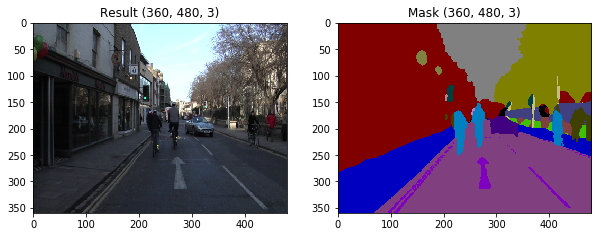

In [0]:
test = image.load_img('test_images/0016E5_08003.png')
imh = image.img_to_array(test)
dims = imh.shape
x = cv2.resize(imh, (128, 128))
x = np.float32(x)/255.
z = unet.predict(np.expand_dims(x, axis=0))
z = np.squeeze(z)
z = cv2.resize(z, (dims[1], dims[0]))
y = np.argmax(z, axis=2)
vb= color_label(y)

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Result {imh.shape}')
ax.imshow(np.uint8(imh))

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {vb.shape}')
ax2.imshow(vb)